In [1]:
from dataget import data
import tfinterface as ti
import sonnet as snt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cytoolz as cz
from dicto import dicto

sess = tf.InteractiveSession()

/home/cristian/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataget
To download and import the data we will use dataget here but you can import the mnist however you want, there are various ways to import the mnist like using keras sample datasets. The first time you run this code `dataget` will download, extract, and transform the `MNIST` to jpg images; any subsequent calls use the cached data. 

In [2]:
dataset = data("mnist").get()

dataset.df.columns

Index([u'class_id', u'filename'], dtype='object')

The `.get` method returns a `Dataset` object which has a `training_set` and `test_set` `SubSet` properties, these subsets include varios methods for loading the images, getting random batches, etc. However, each subset by default include a `.df` property which the columns filename (full path to the actual image) and class_id (number show in the image), although you sometimes wan't a generator of (image, label) batches, we will make TensorFlow do the IO for us so just having the filenames is perfect.

## Estimator API, input_fn & Dataset API
 

In [3]:


def input_fn(df, img_shape = [28, 28], embeddings_shape = [1, 1, 100], epochs = 10, batch_size = 64, buffer_size = 500):
    def parse(filename, class_id):

        img = tf.read_file(filename)
        img = tf.image.decode_jpeg(img, channels = 1)
        img = tf.image.resize_images(img, img_shape)

        return img, class_id

    # ds
    ds = tf.data.Dataset.from_tensor_slices((df.filename.as_matrix(), df.class_id.as_matrix()))
    ds = ds.map(parse)
    ds = ds.shuffle(buffer_size = buffer_size)
    ds = ds.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    ds = ds.repeat(epochs)

    # get iterator
    iterator = ds.make_one_shot_iterator()
    image, class_id = iterator.get_next()

    return dict(image = image, class_id = class_id), None

{'class_id': <tf.Tensor 'IteratorGetNext_1:1' shape=(20,) dtype=int64>, 'image': <tf.Tensor 'IteratorGetNext_1:0' shape=(20, 28, 28, 1) dtype=float32>}


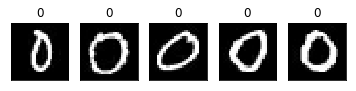

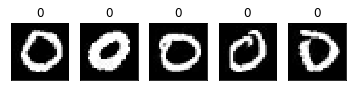

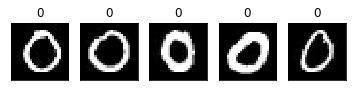

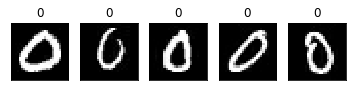

In [9]:
features, _ = input_fn(dataset.df, batch_size=20)

image = features["image"]
class_id = features["class_id"]

print(features)
    
images, class_ids = sess.run([image, class_id])

for tup in cz.partition(5, zip(images, class_ids)):

    fig, axes = plt.subplots(1, 5, subplot_kw=dict())

    for i, (img, class_id) in enumerate(tup):


        img = np.squeeze(img).astype(np.uint8)

        axes[i].imshow(img, cmap="gray")
        axes[i].title.set_text(class_id)
        axes[i].get_yaxis().set_visible(False)
        axes[i].get_xaxis().set_visible(False)

    fig.show()

plt.show()

In [4]:
class AllCNNN(snt.AbstractModule):
    
    def __init__(self, *args, **kwargs):
        kwargs["name"] = kwargs.get("name", "AllCNN")
        super(AllCNNN, self).__init__(*args, **kwargs)
    
    def _build(self, inputs):
        
        print("##########################")
        print("## AllCNN")
        print("##########################")
        
        net = inputs["image"]; print(net)
        training = inputs["mode"] == tf.estimator.ModeKeys.TRAIN
        
        net = tf.layers.conv2d(net, 16, [4, 4], strides = 2, activation = tf.nn.relu, 
                                          padding = "same"); print(net)
        
        
        net = tf.layers.conv2d(net, 32, [4, 4], strides = 2, activation = tf.nn.relu, 
                                          padding = "same"); print(net)
        
        
        net = tf.layers.conv2d(net, 64, [3, 3], strides = 1, activation = tf.nn.relu, 
                                          padding = "valid"); print(net)
        
        
        net = tf.layers.conv2d(net, 10, [3, 3], strides = 1, activation = tf.nn.relu,
                                          padding = "valid"); print(net)
        
        
        
        # global average pooling
        logits = net = tf.reduce_mean(net, axis = [1, 2]); print(net)
        
        # predictions
        predictions = net = tf.nn.softmax(logits); print(net)
    
        print("")
        
        return logits, predictions

In [11]:
inputs = dict(
    image = tf.layers.Input(shape=(28, 28, 1)),
    mode = tf.estimator.ModeKeys.TRAIN,
)

all_cnn = AllCNNN()
logits, predictions = all_cnn(inputs)

##########################
## AllCNN
##########################
Tensor("input_layer_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/conv2d/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/conv2d_2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/conv2d_3/Relu:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_4/Relu:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)



In [5]:
def model_fn(features, labels, mode, params):
    
    inputs = features
    inputs["mode"] = mode
    
    # create networks
    all_cnn = AllCNNN()
    
    # predictions
    logits, predictions = all_cnn(inputs)
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = dict(
                classes = predictions,
                image = inputs["image"],
            )
        )
    
    
    # loss
    labels = inputs["class_id"]
    onehot_labels = tf.one_hot(labels, 10)
    
    loss = tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = onehot_labels)
    loss = tf.reduce_mean(loss)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode = mode,
            predictions = predictions,
            loss = loss,
            eval_metric_ops = dict(
                accuracy = tf.metrics.accuracy(
                    labels = labels,
                    predictions = tf.argmax(predictions, axis = 1)
                )
            )
        )
    
    #update
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        update = tf.train.AdamOptimizer(params["learning_rate"]).minimize(loss, global_step = tf.train.get_global_step())
        
    
    accuracy = tf.contrib.metrics.accuracy(
        labels = labels,
        predictions = tf.argmax(predictions, axis = 1)
    )
        
    # metrics
    tf.summary.scalar("accuracy", accuracy)
    
    
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = update,
        training_hooks = [
            tf.train.LoggingTensorHook(
                dict(
                    loss = loss, 
                    accuracy = accuracy
                ),  
                every_n_iter = 50
            )
        ],
    )

In [13]:
params = dicto.load_("parameters.yml")

estimator = tf.estimator.Estimator(
    model_fn = model_fn,
    model_dir = params.model_dir,
    params = params,
    config = tf.estimator.RunConfig(save_checkpoints_steps = params.checkpoint_steps, save_summary_steps = params.summary_steps)
)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9711c812d0>, '_save_checkpoints_steps': 50, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models/all_cnn3', '_save_summary_steps': 50}


In [ ]:
params = dicto.load_("parameters.yml")

estimator.train(
    input_fn = lambda: input_fn(
        dataset.df, 
        batch_size = params.batch_size, 
        epochs = params.epochs,
    )
)

##########################
## AllCNN
##########################
Tensor("IteratorGetNext:0", shape=(64, 28, 28, 1), dtype=float32, device=/device:CPU:0)
Tensor("AllCNN/conv2d/Relu:0", shape=(64, 14, 14, 16), dtype=float32)
Tensor("AllCNN/conv2d_2/Relu:0", shape=(64, 7, 7, 32), dtype=float32)
Tensor("AllCNN/conv2d_3/Relu:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_4/Relu:0", shape=(64, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(64, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(64, 10), dtype=float32)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from models/all_cnn3/model.ckpt-452
INFO:tensorflow:Saving checkpoints for 453 into models/all_cnn3/model.ckpt.
INFO:tensorflow:loss = 9.063255, step = 453
INFO:tensorflow:loss = 9.063

In [ ]:
params = dicto.load_("parameters.yml")

estimator.evaluate(
    input_fn = lambda: input_fn(
        dataset.df, 
        batch_size = params.batch_size, 
        epochs = 1
    )
)

In [7]:
params = dicto.load_("parameters.yml")

iterator = estimator.predict(
    input_fn = lambda: input_fn(
        dataset.df, 
        batch_size = 64, 
        epochs = 1
    )
)

NameError: name 'estimator' is not defined

In [ ]:
predictions = next(iterator)

img = predictions["image"]
class_id = np.argmax(predictions["classes"])

ax = plt.axes()

plt.imshow(img[:, :, 0], cmap="gray")

ax.title.set_text(class_id)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()

In [8]:
def predict_input_fn():
    return dict(
        image = tf.layers.Input(
            shape = [28, 28, 1],
            name = "input_image"
        )
    )

features = predict_input_fn()
spec = model_fn(features, None, tf.estimator.ModeKeys.PREDICT, params)
predictions = spec.predictions

##########################
## AllCNN
##########################
Tensor("input_image_1:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/conv2d/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/conv2d_2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/conv2d_3/Relu:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_4/Relu:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)



In [9]:
uff_generator = ti.estimator.UFFGenerator(
    predict_input_fn,
    model_fn,
    params.model_dir,
    params,
)

uff_generator.dump(uff_path = "test.uff", model_outputs = params.OUTPUT_NAMES)

##########################
## AllCNN
##########################
Tensor("input_image:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("AllCNN/conv2d/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("AllCNN/conv2d_2/Relu:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("AllCNN/conv2d_3/Relu:0", shape=(?, 5, 5, 64), dtype=float32)
Tensor("AllCNN/conv2d_4/Relu:0", shape=(?, 3, 3, 10), dtype=float32)
Tensor("AllCNN/Mean:0", shape=(?, 10), dtype=float32)
Tensor("AllCNN/Softmax:0", shape=(?, 10), dtype=float32)

INFO:tensorflow:Restoring parameters from models/all_cnn3/model.ckpt-903
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
Using output node AllCNN/Softmax
Converting to UFF graph
No. nodes: 24


In [11]:
model = ti.estimator.UFFPredictor(
    "test.uff",
    dict(input_image = [1, 28, 28]),
    params.OUTPUT_NAMES,
)

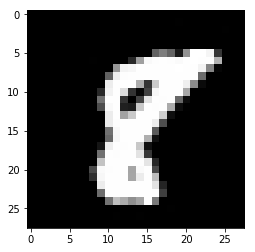

Prediction: [array([[[0.06727481]],

       [[0.06992882]],

       [[0.12380342]],

       [[0.33769906]],

       [[0.06688232]],

       [[0.06688232]],

       [[0.06688232]],

       [[0.06688232]],

       [[0.06688232]],

       [[0.06688232]]], dtype=float32)]


In [26]:
import cv2

im = cv2.imread(dataset.df.filename.iloc[60000])
im = np.mean(im, axis=2, keepdims=True)

plt.imshow(im.squeeze(), cmap="gray")
plt.show()

out = model.predict(im)

print('Prediction: {}'.format(out))

## Freeze Graph

In [ ]:
params = dicto.load_("parameters.yml")

graph = tf.Graph()
with graph.as_default():
    inputs = dict(
        image = tf.layers.Input(shape=(28, 28, 1)),
        mode = tf.estimator.ModeKeys.TRAIN,
    )

    all_cnn = AllCNNN()
    logits, predictions = all_cnn(inputs)
    
    saver = tf.train.Saver()

In [ ]:
params = dicto.load_("parameters.yml")

print(params.model_dir)

sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)
snapshot_fpath = tf.train.latest_checkpoint(params.model_dir)
saver.restore(sess, snapshot_fpath)

In [ ]:
from tensorflow.python.framework import graph_io

params = dicto.load_("parameters.yml")

graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())

graphdef_frozen = tf.graph_util.convert_variables_to_constants(
    sess, graphdef_inf, params.OUTPUT_NAMES)

graph_io.write_graph(graphdef_frozen, './', params.FROZEN_FPATH, as_text=False)

In [ ]:
[x.name for x in graphdef_frozen.node]

## UFF

In [ ]:
import tensorrt as trt
import uff
from tensorrt.parsers import uffparser

MAX_WORKSPACE = 1 << 20 # ADJUST

In [ ]:
params = dicto.load_("parameters.yml")

uff_model = uff.from_tensorflow_frozen_model(
    params.FROZEN_FPATH, 
    params.OUTPUT_NAMES
)

In [ ]:
params = dicto.load_("parameters.yml")

parser = uffparser.create_uff_parser()

for input_ in params.INPUTS:
    parser.register_input(input_.name, input_.size, 0)

for output in params.OUTPUT_NAMES:
    parser.register_output(output)

G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.INTERNAL_ERROR)

In [ ]:
engine = trt.utils.uff_to_trt_engine(
    G_LOGGER, uff_model, parser, params.MAX_BATCH_SIZE, MAX_WORKSPACE)

In [ ]:
trt.utils.write_engine_to_file(params.ENGINE_FPATH, engine.serialize())

In [ ]:
engine = trt.lite.Engine(PLAN=params.ENGINE_FPATH)
type(engine)

In [ ]:
import cv2

im = cv2.imread(dataset.df.filename.iloc[8000])
im = np.mean(im, axis=2, keepdims=True)

im.shape

In [ ]:
plt.imshow(im.squeeze(), cmap="gray")
plt.show()

In [ ]:
out = engine.infer(im)

print('Prediction: {}'.format(np.argmax(out[0])))

In [ ]:
params = dicto.load_("parameters.yml")

graph = tf.Graph()

with graph.as_default(), tf.Session(graph = graph) as sess:
    
    inputs = dict(
        image = tf.layers.Input(shape=(28, 28, 1)),
        mode = tf.estimator.ModeKeys.TRAIN,
    )

    all_cnn = AllCNNN()
    logits, predictions = all_cnn(inputs)
    
    graph_def = graph.as_graph_def()
    saver = tf.train.Saver()
    
    snapshot_fpath = tf.train.latest_checkpoint(params.model_dir)
    saver.restore(sess, snapshot_fpath)
    
    # freeze graph and remove nodes used for training 
    frozen_graph = tf.graph_util.convert_variables_to_constants(sess, graph_def, params.OUTPUT_NAMES)
    frozen_graph = tf.graph_util.remove_training_nodes(frozen_graph)
    # Create UFF model and dump it on disk 
    uff_model = uff.from_tensorflow(frozen_graph, params.OUTPUT_NAMES)
    dump = open('all_cnn.uff', 'wb')
    dump.write(uff_model)
    dump.close()

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import argparse

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This is a helper function, provided by TensorRT devs, to run inference
def infer(context, input_img, batch_size):
    
    # load engine
    engine = context.get_engine()
    assert(engine.get_nb_bindings() == 2)
    
    # create output array to receive data
    dims = engine.get_binding_dimensions(1).to_DimsCHW()
    elt_count = dims.C() * dims.H() * dims.W() * batch_size
    
    # convert input data to Float32
    input_img = input_img.astype(np.float32)
    
    # Allocate pagelocked memory
    output = cuda.pagelocked_empty(elt_count, dtype=np.float32)
    
    # alocate device memory
    d_input = cuda.mem_alloc(batch_size * input_img.size * input_img.dtype.itemsize)
    d_output = cuda.mem_alloc(batch_size * output.size * output.dtype.itemsize)
    bindings = [int(d_input), int(d_output)]
    stream = cuda.Stream()
    
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, input_img, stream)
    
    # execute model
    context.enqueue(batch_size, bindings, stream.handle, None)
    
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    
    # return predictions
    return output

# load model
uff_model = open('all_cnn.uff', 'rb').read()

# create model parser
parser = uffparser.create_uff_parser()

for input in params.INPUTS:
    parser.register_input(input.name, input.size, 0)

for output in params.OUTPUT_NAMES:
    parser.register_output(output)
    
# create inference engine and context (aka session)
trt_logger = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)
engine = trt.utils.uff_to_trt_engine(logger=trt_logger,
                                     stream=uff_model,
                                     parser=parser,
                                     max_batch_size=2, # 1 sample at a time
                                     max_workspace_size= 1 << 30, # 1 GB GPU memory workspace
                                     datatype=trt.infer.DataType.FLOAT) # that's very cool, you can set precision
context = engine.create_execution_context()